In [23]:
# import libraries
import os
import re
import json
import pickle
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,ConfusionMatrixDisplay

from keras import Sequential
from keras.preprocessing.text import Tokenizer
from keras.callbacks import TensorBoard,EarlyStopping
from keras.layers import Dense,Dropout,LSTM,Embedding,GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences

# url of the row dataset
url_raw = 'https://raw.githubusercontent.com/susanli2016/PyCon-Canada-2019-NLP-Tutorial/master/bbc-text.csv'

#%% data loading 
df = pd.read_csv(url_raw)

text = df.iloc[:,-1] # feature
category = df.iloc[:,0] # target

# %% EDA
df.isna().sum()

# %% data cleaning 
for index, data in enumerate(text):
    data = re.sub('[^a-zA-Z]', ' ', data).lower() # sort out number and odd symbol
    text[index] = data

# data preprocessing
#tokenizer
vocab_num = 5000
oov_token = '<OOV>'
tokenizer = Tokenizer(num_words=vocab_num,oov_token=oov_token)
tokenizer.fit_on_texts(text)

#view converted data
text_index = tokenizer.word_index
print(list(text_index)[0:10])

text = tokenizer.texts_to_sequences(text)


maxlen = [len(i) for i in text] #list comprehension
maxlen = int(np.ceil(np.percentile(maxlen,75)))
text = pad_sequences(text,maxlen=maxlen, padding='post',truncating='post') # pading

ohe = OneHotEncoder(sparse=False) #ohe for target 
category = ohe.fit_transform(np.expand_dims(category,axis=-1))

# train test split
text =  np.expand_dims(text,axis=-1)
x_train, x_test, y_train, y_test = train_test_split(text,category,train_size=0.7,shuffle=True,random_state=0)



['<OOV>', 'the', 'to', 'of', 'and', 'a', 'in', 's', 'for', 'is']


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 512)         2560000   
                                                                 
 lstm_20 (LSTM)              (None, None, 512)         2099200   
                                                                 
 dropout_18 (Dropout)        (None, None, 512)         0         
                                                                 
 lstm_21 (LSTM)              (None, 512)               2099200   
                                                                 
 dropout_19 (Dropout)        (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 6,760,965
Trainable params: 6,760,965
No

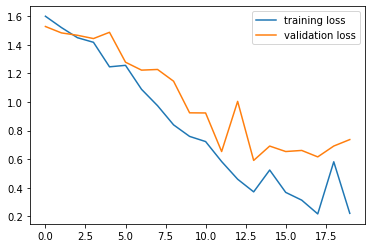

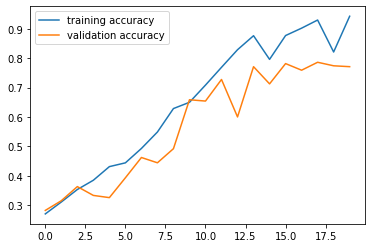

21/21 [==============================] - 2s 66ms/step
              precision    recall  f1-score   support

           0       0.67      0.87      0.76       152
           1       0.46      0.51      0.48       109
           2       0.92      0.84      0.88       113
           3       0.96      0.68      0.79       177
           4       0.92      0.96      0.94       117

    accuracy                           0.77       668
   macro avg       0.79      0.77      0.77       668
weighted avg       0.80      0.77      0.78       668



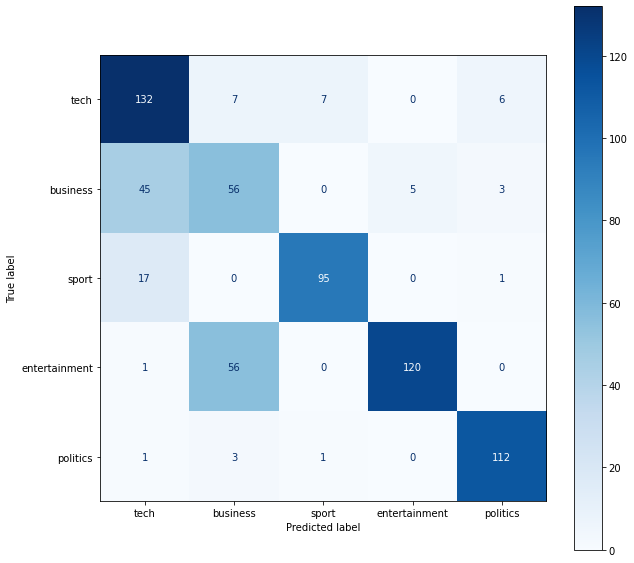

The accuracy score is 0.7709580838323353
The F1-Score is 0.7710078569224207


In [24]:
# model development
embedding_dims = 512
nb_classes = len(np.unique(y_train,axis=0))
input_shape = np.shape(x_train)[1:]
dropout_rate = 0.3


model = Sequential()
model.add(Embedding(vocab_num,embedding_dims)) # input
model.add(LSTM(embedding_dims,input_shape=input_shape,return_sequences=True)) # first hidden layer
model.add(Dropout(dropout_rate))
model.add(LSTM(embedding_dims)) # second hidden layer
model.add(Dropout(dropout_rate))
model.add(Dense(nb_classes,activation='softmax')) # output
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
log_dir = os.path.join(os.getcwd(), datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_callback = TensorBoard(log_dir=log_dir)
es_callback = EarlyStopping(monitor="loss", patience=5)
hist = model.fit(x_train,y_train,batch_size=32, epochs=20, validation_data=(x_test, y_test), callbacks=[tb_callback, es_callback])

# model analysis
plt.figure()
plt.plot(hist.history["loss"])
plt.plot(hist.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.show()

plt.figure()
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.legend(['training accuracy', 'validation accuracy'])
plt.show()

# model prediction
y_pred = model.predict(x_test)
y_true = y_test

y_pred = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_true,axis=1)

print(classification_report(y_true, y_pred)) 

# confusion matrix 
cm = confusion_matrix(y_true,y_pred)
labels = df.iloc[:,0].unique()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.show()

print('The accuracy score is {}'.format(accuracy_score(y_true,y_pred)))
print('The F1-Score is {}'.format(f1_score(y_true,y_pred,average='macro')))



In [ ]:
# model deployment
model.save('model.h5')

# to save ohe
with open('ohe.pkl', 'wb') as f:
    pickle.dump(ohe,f)

# to save tokenizer 
token_json = tokenizer.to_json()
with open('token.json','w') as json_file:
    json.dump(token_json,json_file)

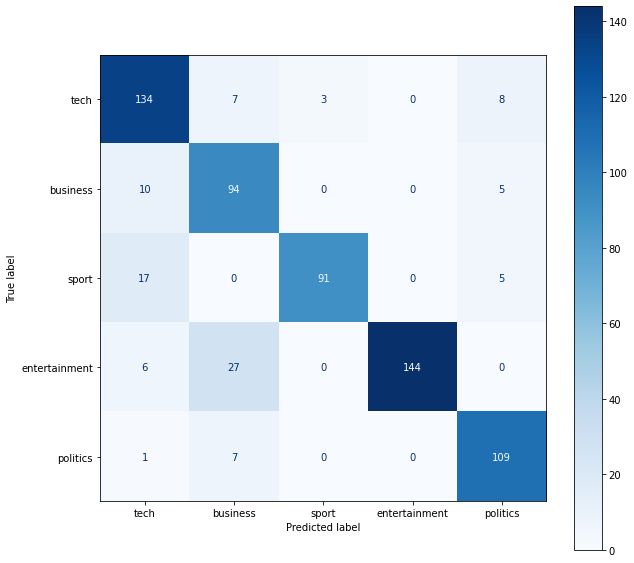

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)